Diagnostics for NR

In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import gw_eccentricity
from gw_eccentricity import get_available_methods
from gw_eccentricity import measure_eccentricity
from gw_eccentricity.load_data import load_waveform
from gw_eccentricity.plot_settings import colorsDict, lstyles, lwidths, figWidthsTwoColDict, figHeightsDict, use_fancy_plotsettings

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [2]:
import glob
import numpy as np
from tqdm import tqdm
from gw_eccentricity.load_data import load_lvcnr_hack

In [3]:
sxs_nr_waveforms = sorted(glob.glob("../data/ecc_waveforms/Non-Precessing/SXS/BBH_S*.h5"))
et_waveforms = sorted(glob.glob("../data/ecc_waveforms/Non-Precessing/ET/*.h5"))

In [4]:
all_nr_waveforms = sorted(np.append(sxs_nr_waveforms, et_waveforms))

In [5]:
# in sxs_nr_waveforms
problematic_cases = [8, # need to increase flow and width 
                     34, # Takes too long to load, did not load within tested time.
                     37, # loads too short waveform
                    ]

In [6]:
num_orbits_dict= {"BBH_SKS_q1_e09_D130_DoNotControlLEqualsOneShape_AdjustSphereCExtents_Res3.h5": 3,
                 "BBH_SKS_q1_e09_D130_SKS_DoNotControlLEqualsOneShape_Res3.h5": 3}

In [7]:
def MakeDiagnosticPlots(methods, nr_waveforms, num_orbits_dict):
    """loop through all NR waveforms, and make diagnostics plots 
         methods - list of methods to apply
         nr_waveforms - list of paths to NR waveforms to apply methods to
    """

    # make output objects, one per method
    pps = [PdfPages(f"NR-diagnostics-{method}.pdf") for method in methods]


    comparisons = PdfPages("NR_diagnostics-comparisons.pdf")

    for idx, waveform_path in enumerate(nr_waveforms):
        w = waveform_path.split("/")[-1]
        print(f"===== {idx}/{len(nr_waveforms)} ===== {w} =====", flush=True)
        kwargs = {"filepath": waveform_path,
                "include_zero_ecc": True,
                "num_orbits_to_remove_as_junk": num_orbits_dict.get(w, 3)}
        dataDict = load_lvcnr_hack(**kwargs)
        tref_vec = dataDict["t"]


        # for ecc-comparison plot
        fig0, ax0 = plt.subplots(figsize=(12, 6))

        for method,pp in zip(methods, pps):
            tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(
                tref_in=tref_vec,
                dataDict=dataDict,
                method=method, 
                return_gwecc_object=True,
                extra_kwargs={"debug": False})
            fig, ax = eccMethod.make_diagnostic_plots(twocol=True)
            q = dataDict["params_dict"]["q"]
            ecc = dataDict["params_dict"]["ecc"]
            chi1 = np.around(dataDict["params_dict"]["chi1"], 5)
            chi2 = np.around(dataDict["params_dict"]["chi2"], 5)
            title = (f"case {idx}/{len(sxs_nr_waveforms)-1}, "
                    f"$q$={q:.1f}, "
                    f"$\chi_{1}$={chi1}, "
                    f"$\chi_{2}$={chi2}, "
                    f"ecc={ecc:.2f}\n"
                    f"method={method}, "
                    f"id={w}")
            fig.suptitle(title, ha="center", fontsize=10)
            fig.set_tight_layout(True)
            fig.savefig(pp,format='pdf')
            plt.close(fig)

            eccMethod.plot_measured_ecc(fig0, ax0, add_vline_at_tref=True if method == methods[0] else False, **{"label": method, "lw": lwidths[method], "ls": lstyles[method], "c": colorsDict[method]})
        ax0.set_title(f"q={q:.1f}, ecc={ecc:.2f}, {w}", fontsize=14)
        ax0.legend();
        fig0.savefig(comparisons,format='pdf')
        plt.close(fig0)

    for pp in pps:
        pp.close()
    comparisons.close()

In [8]:
# to test, analyse only two waveforms:
MakeDiagnosticPlots(gw_eccentricity.get_available_methods(), sxs_nr_waveforms[30:32], num_orbits_dict)

===== 0/2 ===== BBH_SHK_q3_e04_D28_Res3.h5 =====
===== 1/2 ===== BBH_SHK_q3_e08_D55_Res3.h5 =====


In [8]:
# ALL SXS-WAVEFORMS.  THIS TAKES A FEW MINUTES !!!
MakeDiagnosticPlots(gw_eccentricity.get_available_methods(), sxs_nr_waveforms, num_orbits_dict)

===== 0/61 ===== BBH_SHK_q10_e01_D14.5_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 1/61 ===== BBH_SHK_q10_e01_D16_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 2/61 ===== BBH_SHK_q10_e05_D28_Res3.h5 =====
===== 3/61 ===== BBH_SHK_q10_e05_D30_Res3.h5 =====
===== 4/61 ===== BBH_SHK_q10_e07_D45_Res3.h5 =====
===== 5/61 ===== BBH_SHK_q1_0_0_e01_D16_FastDyn_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 6/61 ===== BBH_SHK_q1_0_0_e01_D20_Res3.h5 =====
===== 7/61 ===== BBH_SHK_q1_0_0_e02_D18_Res3.h5 =====
===== 8/61 ===== BBH_SHK_q1_0_0_e02_D22_Res3.h5 =====
===== 9/61 ===== BBH_SHK_q1_0_0_e05_D34_Res3.h5 =====
===== 10/61 ===== BBH_SHK_q1_e035_D26_Res3.h5 =====
===== 11/61 ===== BBH_SHK_q1_e04_D28_Res3.h5 =====
===== 12/61 ===== BBH_SHK_q1_e07_D45_Res3.h5 =====
===== 13/61 ===== BBH_SHK_q1_e08_D60_Res3.h5 =====
===== 14/61 ===== BBH_SHK_q1_e095_D65_Res3.h5 =====
===== 15/61 ===== BBH_SHK_q1_e09_D70_Res3.h5 =====
===== 16/61 ===== BBH_SHK_q2_e01_D18_Res3.h5 =====
===== 17/61 ===== BBH_SHK_q2_e02_D20_Res3.h5 =====
===== 18/61 ===== BBH_SHK_q2_e035_D26_Res3.h5 =====
===== 19/61 ===== BBH_SHK_q2_e04_D28_Res3.h5 =====
===== 20/61 ===== BBH_SHK_q2_e05_D34_Res3.h5 =====
===== 21/61 ===== BBH_SHK_q2_e08_D60_Res3.h5 =====
===== 22/61 ===== BBH_SHK_q2_e095_D65_Res3.h5 =====
===== 23/61 ===== BBH_SHK_q3_e01_D22_Res3.h5 =====
===== 24/61 ===== BBH_SHK_q3_e025_D22_Res3.h5 =====
===== 25/61 ==

/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.06482649065037549. Times of occurrences are [-8529.88525572]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 12.080737406418478. Times of occurrences are [-7548.98525572]
  warnings.warn(f"At leas

===== 46/61 ===== BBH_SHK_q8_e01_D14.5_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:450: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:685: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(


===== 47/61 ===== BBH_SHK_q8_e02_D20_Res3.h5 =====
===== 48/61 ===== BBH_SHK_q8_e035_D26_Res3.h5 =====
===== 49/61 ===== BBH_SHK_q8_e04_D28_Res3.h5 =====
===== 50/61 ===== BBH_SHK_q8_e05_D28_Res3.h5 =====
===== 51/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e025_D22_Res3.h5 =====
===== 52/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e02_D22_Res3.h5 =====
===== 53/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e04_D28_Res3.h5 =====
===== 54/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 =====
===== 55/61 ===== BBH_SKS_q10_-0.75_0_e05_D28_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:685: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 11.59306482111566. Times of occurrences are [-2484.22753189]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 1.6221724874718646. Times of occurrences are [-3195.3275319]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1

===== 56/61 ===== BBH_SKS_q1_-0.75_-0.75_e07_D45_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:685: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.10341630755333853. Times of occurrences are [-6760.44010759]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 10.322872333901685. Times of occurrences are [-5878.54010759]
  warnings.warn(f"At least a pair of {extrema_type} are too far."


===== 57/61 ===== BBH_SKS_q1_0.75_0.75_e07_D45_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 3. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 9.767205115201222. Times of occurrences are [-14198.36024439]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.12293185642160154. Times of occurrences are [-15652.36024437 -14638.66024438 -13712.560

===== 58/61 ===== BBH_SKS_q1_0.9_0.9_e05_D28_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.22959956968837147. Times of occurrences are [-9601.72655884]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 8.534371615420554. Times of occurrences are [-8986.92655883]
  warnings.warn(f"At least

===== 59/61 ===== BBH_SKS_q1_e09_D130_DoNotControlLEqualsOneShape_AdjustSphereCExtents_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:643: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.037841946546084415. Times of occurrences are [-6717.42448362]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 10.795491125821371. Times of occurrences are [-5445.52448361]
  warnings.warn(f"At lea

===== 60/61 ===== BBH_SKS_q1_e09_D130_SKS_DoNotControlLEqualsOneShape_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:685: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:596: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 10.386346482137355. Times of occurrences are [-6100.49718692]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:685: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:590: UserWarning: At least

### Compare ecc vs time plot for different methods with varying num orbits before merger

In [8]:
def MakeDiagnosticPlotsAsFunctionOfNumOrbits(methods, nr_waveforms, list_num_orbits_to_exclude_before_merger, style="APS"):
    """loop through all NR waveforms, and make diagnostics plots.
    
    For different methods by varying the num orbits before merger variable.
    
    Parameters:
    -----------
    methods:
        list of methods to apply.
        
    nr_waveforms:
        list of paths to NR waveforms to apply methods to.
        
    list_num_orbits_to_exclude_before_merger:
        list of num orbits to exclude before mergers.
    
    style:
        Settings for plots.
    """

    # make output object
    num_strings = "_".join([f"{x:.1f}" for x in list_num_orbits_to_exclude_before_merger])
    pp = PdfPages(f"NR-diagnostics-for-num-orbits_{num_strings}.pdf")

    for idx, waveform_path in enumerate(nr_waveforms):
        w = waveform_path.split("/")[-1]
        print(f"===== {idx}/{len(nr_waveforms)} ===== {w} =====", flush=True)
        kwargs = {"filepath": waveform_path,
                "include_zero_ecc": True,
                "num_orbits_to_remove_as_junk": num_orbits_dict.get(w, 3)}
        dataDict = load_lvcnr_hack(**kwargs)
        tref_vec = dataDict["t"]


        # for ecc-comparison plot
        nrows = len(list_num_orbits_to_exclude_before_merger)
        use_fancy_plotsettings(style=style)
        fig, axes = plt.subplots(nrows=nrows, figsize=(figWidthsTwoColDict[style], nrows * figHeightsDict[style]),
                                sharex=True)
        if nrows == 1:
            axes = [axes]
    
        for idx1, num_orbits in enumerate(list_num_orbits_to_exclude_before_merger):
            for idx2, method in enumerate(methods):
                try:
                    tref_out, ecc_vec, mean_ano_vec, gwecc_obj = measure_eccentricity(
                        tref_in=tref_vec,
                        dataDict=dataDict,
                        method=method, 
                        return_gwecc_object=True,
                        extra_kwargs={"debug": False,
                                     "num_orbits_to_exclude_before_merger": num_orbits})
                    gwecc_obj.plot_measured_ecc(fig, axes[idx1], add_vline_at_tref=True if idx2 == 0 else False,
                                                **{"label": method,
                                                   "c": colorsDict[method],
                                                   "ls": lstyles[method],
                                                   "lw": lwidths[method]})
                except Exception:
                    print(f"{method} Fails for {w} with {num_orbits}.")
            axes[idx1].text(0.99, 0.95, f"number of orbits = {num_orbits:.1f}", transform=axes[idx1].transAxes,
                           ha="right", va="top", fontsize=10)
            axes[idx1].set_xlabel("")
        axes[0].legend(labelspacing=0.2, handlelength=1, fontsize=10)
        axes[-1].set_xlabel(r"$t$ [$M$]")
        q = dataDict["params_dict"]["q"]
        ecc = dataDict["params_dict"]["ecc"]
        chi1 = np.around(dataDict["params_dict"]["chi1"], 5)
        chi2 = np.around(dataDict["params_dict"]["chi2"], 5)
        title = (f"case {idx}/{len(sxs_nr_waveforms)-1}, "
                f"$q$={q:.1f}, "
                f"$\chi_{1}$={chi1}, "
                f"$\chi_{2}$={chi2}, "
                f"ecc={ecc:.2f}\n"
                f"id={w}")
        axes[0].set_title(title, ha="center", fontsize=10)
        fig.set_tight_layout(True)
        fig.savefig(pp,format='pdf')
        plt.close(fig)
    pp.close()

In [9]:
MakeDiagnosticPlotsAsFunctionOfNumOrbits(get_available_methods(), sxs_nr_waveforms, [1, 2, 3, 4])

===== 0/61 ===== BBH_SHK_q10_e01_D14.5_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 1/61 ===== BBH_SHK_q10_e01_D16_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 2/61 ===== BBH_SHK_q10_e05_D28_Res3.h5 =====
===== 3/61 ===== BBH_SHK_q10_e05_D30_Res3.h5 =====
===== 4/61 ===== BBH_SHK_q10_e07_D45_Res3.h5 =====
===== 5/61 ===== BBH_SHK_q1_0_0_e01_D16_FastDyn_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")


===== 6/61 ===== BBH_SHK_q1_0_0_e01_D20_Res3.h5 =====
===== 7/61 ===== BBH_SHK_q1_0_0_e02_D18_Res3.h5 =====
===== 8/61 ===== BBH_SHK_q1_0_0_e02_D22_Res3.h5 =====
===== 9/61 ===== BBH_SHK_q1_0_0_e05_D34_Res3.h5 =====
===== 10/61 ===== BBH_SHK_q1_e035_D26_Res3.h5 =====
===== 11/61 ===== BBH_SHK_q1_e04_D28_Res3.h5 =====
===== 12/61 ===== BBH_SHK_q1_e07_D45_Res3.h5 =====
===== 13/61 ===== BBH_SHK_q1_e08_D60_Res3.h5 =====
===== 14/61 ===== BBH_SHK_q1_e095_D65_Res3.h5 =====
===== 15/61 ===== BBH_SHK_q1_e09_D70_Res3.h5 =====
===== 16/61 ===== BBH_SHK_q2_e01_D18_Res3.h5 =====
===== 17/61 ===== BBH_SHK_q2_e02_D20_Res3.h5 =====
===== 18/61 ===== BBH_SHK_q2_e035_D26_Res3.h5 =====
===== 19/61 ===== BBH_SHK_q2_e04_D28_Res3.h5 =====
===== 20/61 ===== BBH_SHK_q2_e05_D34_Res3.h5 =====
===== 21/61 ===== BBH_SHK_q2_e08_D60_Res3.h5 =====
===== 22/61 ===== BBH_SHK_q2_e095_D65_Res3.h5 =====
===== 23/61 ===== BBH_SHK_q3_e01_D22_Res3.h5 =====
===== 24/61 ===== BBH_SHK_q3_e025_D22_Res3.h5 =====
===== 25/61 ==

/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:662: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.06482649065037549. Times of occurrences are [-8529.88525572]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 12.080737406418478. Times of occurrences are [-7548.98525572]
  warnings.warn(f"At leas

===== 46/61 ===== BBH_SHK_q8_e01_D14.5_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:465: UserWarning: Encountered negative eccentricity.
  warnings.warn("Encountered negative eccentricity.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(


===== 47/61 ===== BBH_SHK_q8_e02_D20_Res3.h5 =====
===== 48/61 ===== BBH_SHK_q8_e035_D26_Res3.h5 =====
===== 49/61 ===== BBH_SHK_q8_e04_D28_Res3.h5 =====
===== 50/61 ===== BBH_SHK_q8_e05_D28_Res3.h5 =====
===== 51/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e025_D22_Res3.h5 =====
===== 52/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e02_D22_Res3.h5 =====
===== 53/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e04_D28_Res3.h5 =====
===== 54/61 ===== BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 1.1591288090788865. Times of occurrences are [-957.45101901]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 10.431235960467184. Times of occurrences are [-606.05101901]
  warnings.warn(f"At least a pair of {extrema_type} are too far."


FrequencyFits Fails for BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 with 3.
ResidualAmplitude Fails for BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 with 4.
ResidualFrequency Fails for BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 with 4.
FrequencyFits Fails for BBH_SKS_q1.1_-0.4_-0.7_e05_D28_Res3.h5 with 4.
===== 55/61 ===== BBH_SKS_q10_-0.75_0_e05_D28_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 11.59306482111566. Times of occurrences are [-2484.22753189]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 1.6221724874718646. Times of occurrences are [-3195.3275319]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1

===== 56/61 ===== BBH_SKS_q1_-0.75_-0.75_e07_D45_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.10341630755333853. Times of occurrences are [-6760.44010759]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 10.322872333901685. Times of occurrences are [-5878.54010759]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/hom

===== 57/61 ===== BBH_SKS_q1_0.75_0.75_e07_D45_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:662: UserWarning: Number of pericenters and number of apocenters differ by 3. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 9.767205115201222. Times of occurrences are [-14198.36024439]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.12293185642160154. Times of occurrences are [-15652.36024437 -14638.66024438 -13712.560

===== 58/61 ===== BBH_SKS_q1_0.9_0.9_e05_D28_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:662: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.22959956968837147. Times of occurrences are [-9601.72655884]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 8.534371615420554. Times of occurrences are [-8986.92655883]
  warnings.warn(f"At least

===== 59/61 ===== BBH_SKS_q1_e09_D130_DoNotControlLEqualsOneShape_AdjustSphereCExtents_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:662: UserWarning: Number of pericenters and number of apocenters differ by 2. This implies that pericenters and apocenters are not appearing alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least a pair of apocenters are too close. Minimum orbital phase diff is 0.037841946546084415. Times of occurrences are [-6717.42448362]
  warnings.warn(f"At least a pair of {extrema_type} are too close."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of apocenters are too far. Maximum orbital phase diff is 10.795491125821371. Times of occurrences are [-5445.52448361]
  warnings.warn(f"At lea

===== 60/61 ===== BBH_SKS_q1_e09_D130_SKS_DoNotControlLEqualsOneShape_Res3.h5 =====


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:614: UserWarning: Phase shift closer to pi than 2 pi detected.
  warnings.warn("Phase shift closer to pi than 2 pi detected.")
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:626: UserWarning: At least a pair of pericenters are too far. Maximum orbital phase diff is 10.386346482137355. Times of occurrences are [-6100.49718692]
  warnings.warn(f"At least a pair of {extrema_type} are too far."
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:706: UserWarning: There is at least one instance where pericenters and apocenters do not appear alternately.
  warnings.warn(
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccDefinition.py:608: UserWarning: At least

### PhenomT vs Surrogate for zeroecc data

In [9]:
def MakeDiagnosticPlotsWithPhenomTVsSurrogate(nr_waveforms, list_num_orbits_to_exclude_before_merger, style="APS", method="ResidualAmplitude"):
    """loop through all NR waveforms, and make diagnostics plots.
    
    Using PhenomT and Surrogate for zeroecc data and by varying the num orbits before merger variable.
    
    Parameters:
    -----------
    nr_waveforms:
        list of paths to NR waveforms to apply methods to.
        
    list_num_orbits_to_exclude_before_merger:
        list of num orbits to exclude before mergers.
    
    style:
        Settings for plots.
    """
    colors = ["tab:orange", "tab:blue"]
    lStyles = ["-", "--"]
    lws = [1, 2]
    # make output object
    num_strings = "_".join([f"{x:.1f}" for x in list_num_orbits_to_exclude_before_merger])
    pp = PdfPages(f"NR-diagnostics-for-num-orbits_{num_strings}_PhenomT-vs-Surrogate.pdf")

    for idx, waveform_path in enumerate(nr_waveforms):
        w = waveform_path.split("/")[-1]
        print(f"===== {idx}/{len(nr_waveforms)} ===== {w} =====", flush=True)
        # for ecc-comparison plot
        nrows = len(list_num_orbits_to_exclude_before_merger)
        use_fancy_plotsettings(style=style)
        fig, axes = plt.subplots(nrows=nrows, figsize=(figWidthsTwoColDict[style], nrows * figHeightsDict[style]),
                                sharex=True)
        if nrows == 1:
            axes = [axes]
    
        for idx1, num_orbits in enumerate(list_num_orbits_to_exclude_before_merger):
            for idx2, use_surrogate in enumerate([True, False]):
                label = "Surrogate" if use_surrogate else "PhenomT"
                kwargs = {"filepath": waveform_path,
                          "include_zero_ecc": True,
                          "num_orbits_to_remove_as_junk": num_orbits_dict.get(w, 3),
                          "use_surrogate_for_zeroecc": use_surrogate}
                dataDict = load_lvcnr_hack(**kwargs)
                tref_vec = dataDict["t"]
                try:
                    tref_out, ecc_vec, mean_ano_vec, gwecc_obj = measure_eccentricity(
                        tref_in=tref_vec,
                        dataDict=dataDict,
                        method=method, 
                        return_gwecc_object=True,
                        extra_kwargs={"debug": False,
                                     "num_orbits_to_exclude_before_merger": num_orbits})
                    gwecc_obj.plot_measured_ecc(fig, axes[idx1], add_vline_at_tref=True if idx2 == 0 else False,
                                                **{"label": label,
                                                   "c": colors[idx2],
                                                   "ls": lStyles[idx2],
                                                   "lw": lws[idx2]})
                except Exception:
                    print(f"{use_surrogate} Fails for {w} with {num_orbits}.")
            axes[idx1].text(0.99, 0.95, f"number of orbits = {num_orbits:.1f}", transform=axes[idx1].transAxes,
                           ha="right", va="top", fontsize=10)
            axes[idx1].set_xlabel("")
        axes[0].legend(labelspacing=0.2, handlelength=1, fontsize=10)
        axes[-1].set_xlabel(r"$t$ [$M$]")
        q = dataDict["params_dict"]["q"]
        ecc = dataDict["params_dict"]["ecc"]
        chi1 = np.around(dataDict["params_dict"]["chi1"], 5)
        chi2 = np.around(dataDict["params_dict"]["chi2"], 5)
        title = (f"case {idx}/{len(sxs_nr_waveforms)-1}, "
                f"$q$={q:.1f}, "
                f"$\chi_{1}$={chi1}, "
                f"$\chi_{2}$={chi2}, "
                f"ecc={ecc:.2f}\n"
                f"id={w}")
        axes[0].set_title(title, ha="center", fontsize=10)
        fig.set_tight_layout(True)
        fig.savefig(pp,format='pdf')
        plt.close(fig)
    pp.close()

In [10]:
MakeDiagnosticPlotsWithPhenomTVsSurrogate(sxs_nr_waveforms[0:2], [1, 2, 3, 4])

===== 0/2 ===== BBH_SHK_q10_e01_D14.5_Res3.h5 =====
Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/eccD

Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0000 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


===== 1/2 ===== BBH_SHK_q10_e01_D16_Res3.h5 =====
Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


Loaded NRHybSur3dq8 model


/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwsurrogate/surrogate.py:1508: UserWarning: Mass ratio q=10.0001 is outside training range: 1<=q<=8.0100
  warnings.warn('Mass ratio q=%.4f is outside training '
/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


### Last good extrema 

In [37]:
waveform_path = sxs_nr_waveforms[10]
w = waveform_path.split("/")[-1]
kwargs = {"filepath": waveform_path,
          "include_zero_ecc": True,
          "num_orbits_to_remove_as_junk": num_orbits_dict.get(w, 3)}
dataDict = load_lvcnr_hack(**kwargs)
tref_vec = dataDict["t"]

Loaded NRHybSur3dq8 model


/home1/md.shaikh/Eccentricity/notebook/../gw_eccentricity/load_data.py:564: UserWarning: Too many tries to reset Momega0 for generating zeroecc modes. Total number of tries = 2
  warnings.warn("Too many tries to reset Momega0 for generating"


In [38]:
tref_out, ecc_vec, mean_ano_vec, gwecc_obj = measure_eccentricity(
                        tref_in=tref_vec,
                        dataDict=dataDict,
                        method="ResidualAmplitude", 
                        return_gwecc_object=True,
                        extra_kwargs={"debug": False})

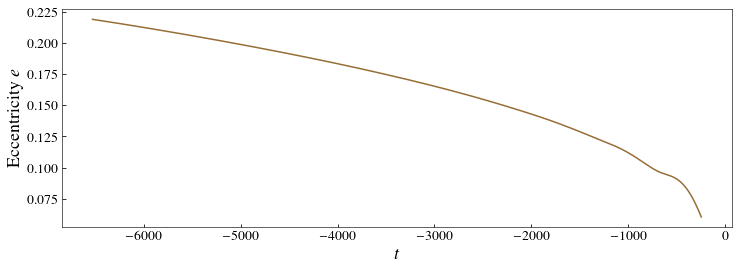

In [39]:
fig, ax = gwecc_obj.plot_measured_ecc()

In [40]:
gwecc_obj.pericenters_location

array([ 3655,  9669, 15466, 21042, 26397, 31528, 36433, 41104, 45538,
       49727, 53660, 57325, 60702, 63766, 66470])

In [41]:
last_peri = gwecc_obj.get_last_good_extrema_from_res_omega22_ratio(gwecc_obj.pericenters_location, max_ratio=1.05)
last_peri

66470

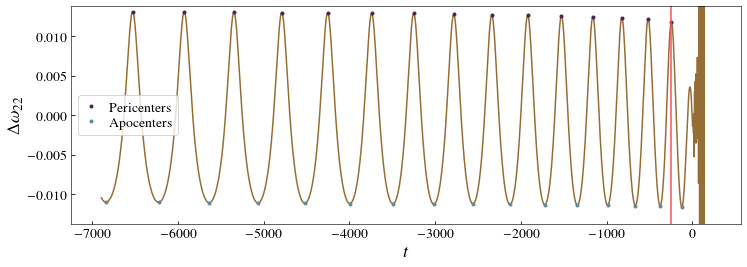

In [42]:
fig, ax = gwecc_obj.plot_residual_omega22()
ax.axvline(gwecc_obj.t[last_peri])
# ax.set_xlim(gwecc_obj.t[last_peri] - 500, gwecc_obj.t[last_peri] + 500)

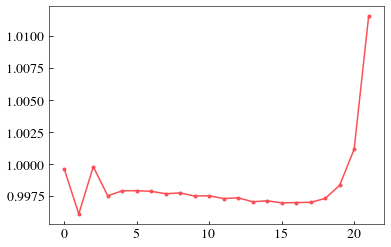

In [106]:
plt.plot(gwecc_obj.res_omega22[gwecc_obj.pericenters_location][1:] / gwecc_obj.res_omega22[gwecc_obj.pericenters_location][:-1], marker=".")

In [86]:
gwecc_obj.apocenters_location

array([  4489,   9173,  13795,  18356,  22858,  27296,  31666,  35977,
        40219,  44391,  48495,  52532,  56491,  60374,  64187,  67918,
        71561,  75123,  78596,  81981,  85269,  88454,  91532,  94499,
        97354, 100080])

In [87]:
last_apo = gwecc_obj.get_last_extrema_from_res_omega22_ratio(gwecc_obj.apocenters_location, max_ratio=1.05)
last_apo

100080

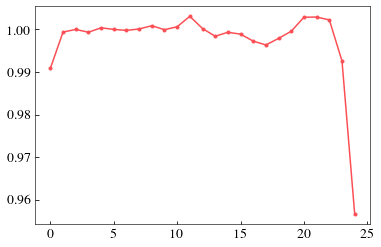

In [88]:
plt.plot(gwecc_obj.res_omega22[gwecc_obj.apocenters_location][1:] / gwecc_obj.res_omega22[gwecc_obj.apocenters_location][:-1], marker=".")